## In-class coding exercise
1.  Code momentum method into the 2-layer classifier that you saw in the last lecture.  Extract gradients using the built-in tensorflow tf.gradients() function, construct the extra memory variables that the momentum method requires and code the assign functions to do the updates.  
2.  Use the tensorflow built-in function tf.train.MomentumOptimizer and compare results

(400, 1)


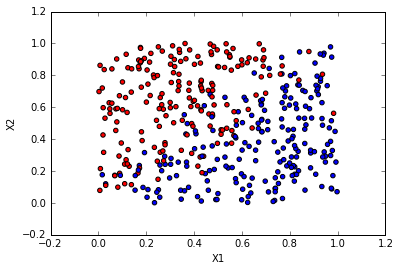

In [1]:
#code for 2-layer classifier network-Momentum

# Copied from lecture -- Data generator
import matplotlib.pyplot as plot
%matplotlib inline
import tensorflow as tf
import numpy as np

sd = 0.2
nRows = 400
X = np.random.uniform(0.0, 1.0, (nRows, 2))
noise = np.random.normal(0.0, sd, nRows)
idx = X[:, 1] > X[:, 0] + noise
Y = np.zeros((nRows, 1))
Y[idx] = 1.0
print Y.shape

colorMap = {0.0: "blue", 1.0: "red"}
colors = [colorMap[c] for c in Y.reshape(-1)]
plot.scatter(X[:, 0], X[:, 1], c=colors)
plot.xlabel("X1")
plot.ylabel("X2")
plot.show()

In [2]:
# Copied from last lecture

def tfS(XX):
    return 1.0 / (1.0 + tf.exp(-XX)) 

def tfNeuralNet(XX, W):
    return tfS(tf.matmul(XX, W))

def tfLoss(NNO, Y):
    return tf.reduce_mean((Y - NNO) ** 2)

def tfGradW(XX, Y, W):
    arg = tf.matmul(XX, W)
    terms = -2.0 * (Y - tfS(arg)) * tfS(arg) * tfS(-arg)
    return tf.reduce_mean((terms * XX), 0)


x = tf.placeholder(tf.float32, shape=[None, 2], name='x')
y = tf.placeholder(tf.float32, shape=[None, 1], name='y')
W2 = tf.Variable(tf.zeros((2,1), dtype=tf.float32), name='W2') 

nno = tfNeuralNet(x, W2)
loss = tfLoss(nno, y)
grad = tfGradW(x, y, W2)

In [3]:
# constants and variables for momentum method
step = tf.Variable(tf.zeros((2,1), dtype=tf.float32), name='step')
beta = tf.constant(0.85, dtype=tf.float32, name='beta')
delta = tf.constant(0.5, dtype=tf.float32, name='delta')

# step update
udStep = step.assign(beta * step - (1 - beta) * delta * tf.reshape(grad, (2, 1)))
udWt = W2.assign(W2 + step)

loss history


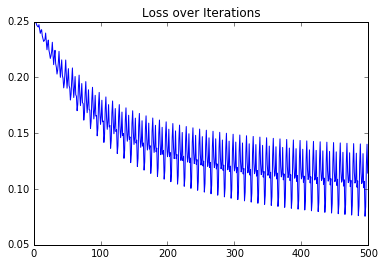

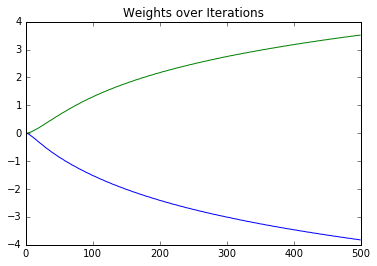

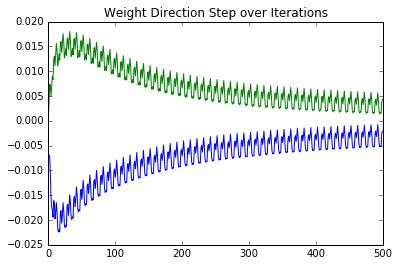

In [4]:
# manual momentum
with tf.Session() as sess:
    result = sess.run(tf.initialize_all_variables())
    miniBatchSize = 40
    startEnd = zip(range(0, len(X), miniBatchSize), range(miniBatchSize, len(X) + 1, miniBatchSize))
    lossList = []

    weights = [] ### new line
    weight_step = [] ### new line
    
    nPasses = 50
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            lossVal, step_direction, weight = sess.run([loss, udStep, udWt], feed_dict={x: X[s:e,], y: Y[s:e]})
            lossList.append(lossVal)
            weight_step.append(step_direction)
            weights.append(weight)
            
            
xAxis = range(len(lossList))
print 'loss history'
plot.plot(xAxis, lossList)
plot.title("Loss over Iterations")
plot.show()
plot.plot(np.array(weights).reshape((-1, 2)))
plot.title("Weights over Iterations")
plot.show()
plot.plot(np.array(weight_step).reshape((-1, 2)))
plot.title("Weight Direction Step over Iterations")
plot.show()

loss history


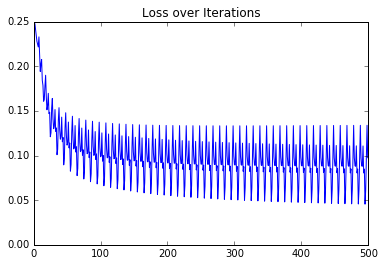

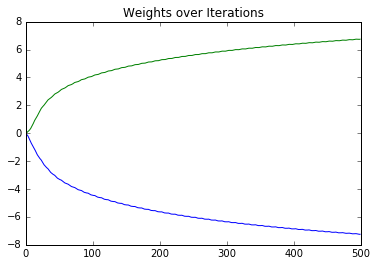

In [5]:
# using tf.train.MomentumOptimizer() instead
with tf.Session() as sess:
    
    weight_updater = tf.train.MomentumOptimizer(learning_rate=0.5, momentum=0.85).minimize(loss)
    result = sess.run(tf.initialize_all_variables())
    miniBatchSize = 40
    startEnd = zip(range(0, len(X), miniBatchSize), range(miniBatchSize, len(X) + 1, miniBatchSize))
    lossList = []

    weights = [] ### new line
    weight_step = [] ### new line
    
    nPasses = 50
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            lossVal, _, weight = sess.run([loss, weight_updater, W2], feed_dict={x: X[s:e,], y: Y[s:e]})
            lossList.append(lossVal)
            weight_step.append(step_direction)
            weights.append(weight)
            
            
xAxis = range(len(lossList))
print 'loss history'
plot.plot(xAxis, lossList)
plot.title("Loss over Iterations")
plot.show()
plot.plot(np.array(weights).reshape((-1, 2)))
plot.title("Weights over Iterations")
plot.show()

## In-Class coding exercises

1.  Change to Glorot, Bengio initial weights and tanh non-linearities and rerun.  You can make those changes by  uncommenting the code above
2.  Pick a configuration and switch to AdaGrad, AdaDelta or NAG updates (keeping Glorot, Bengio initial wts).  What is the difference?

In [6]:
# No code for this one yet

## Q's

1.  There are 10000 rows of x's and y's for training and for testing.  Explain the other dimension of the xTrain and xTest arrays.  

## In-class coding exercise

Adapt the 2-layer MNIST code from last lecture to train a classifier for the cifar images.  

In [3]:
# 2-layer cifar

# switched test and training set to train faster
# used original training set as test set to print accuracy per 5 epochs

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from cifarHandler import cifar
from math import sqrt

xTrain, yTrain, xTest, yTest = cifar()

tf.reset_default_graph() 
g = tf.Graph() 
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 3072]) # effectively the first layer; minibatch_size by 784 matrix
    Y = tf.placeholder(tf.float32, shape=[None, 10]) # true image class. this is a one-hot coded matrix, minibatch_size by 10

    lr = tf.constant(0.002, dtype=tf.float32, name='lr')
    weight_shape = [3072, 10] # weight matrix shape for weight matrix between 1st and 2nd layer
    [n_inputs, n_outputs] = weight_shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))  #from glorot paper
    #Pick one of the following initializations for weights: idea is neural net to train faster
    w = tf.Variable(tf.random_normal(weight_shape, stddev=0.01), name='w')   #avant de -glorot
    #w = tf.Variable(tf.random_uniform(weight_shape, -init_range, init_range), name='w')   #apres glorot

    #define network
    logits = tf.matmul(X, w) # matrix multiplication between 1st and 2nd layer, minibatch_size by 10 matrix 
    py_x = tf.nn.softmax(logits) # this is second layer; minibatch_size by 10 matrix
    y_pred = tf.argmax(py_x, dimension=1) # predicting 1 class for each image, minibatch_size by 1 matrix

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost') # cost per image, minibatch_size by 1 matrix
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost') # average cost over all images. actual loss value

    #extract gradients
    gradients = tf.gradients(cost, [w], name='gradients')[0] # wow! 1 line to get gradient wrt to complicated cost function

    #take training steps; backpropogation
    trainW = w.assign(w - lr * gradients)

    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weights over time', w)
    merged = tf.merge_summary([summary1, summary2]) 
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 40
    startEnd = zip(range(0, len(xTest), miniBatchSize), range(miniBatchSize, len(xTest) + 1, miniBatchSize))
    costList = []
    nPasses = 31
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            costVal, weight, tbSummary = sess.run([cost, trainW, merged], feed_dict={X: xTest[s:e,], Y: yTest[s:e]})
            # When trainW is called, it will return the updated weights
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 5 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTrain})
            print iPass, np.mean(np.argmax(yTrain, axis=1) == testResult) #accuracy

0 0.1463
5 0.182
10 0.2265
15 0.2526
20 0.1853
25 0.1917
30 0.2277


## Homework exercise
Code a standard 3 layer ANN for classifying Cifar images.

In [4]:
# 3-layer cifar

# switched test and training set to train faster
# used original training set as test set to print accuracy per 5 epochs

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from cifarHandler import cifar
from math import sqrt


xTrain, yTrain, xTest, yTest = cifar()


#build and initialize weights
def init_weights(shape, name, glorot=False):
    [n_inputs, n_outputs] = shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))
    if glorot:
        return tf.Variable(tf.random_uniform(shape, -init_range, init_range), name=name)
    else:
        return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
    
def gdUpdate(W, G, lr):
    for (w, g) in zip(W, G):
        w.assign(w - lr * g)
    return W[0]


tf.reset_default_graph() 
graph = tf.Graph() 
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, 3072])
    Y = tf.placeholder(tf.float32, shape=[None, 10])
    lr = tf.constant(0.000001, dtype=tf.float32, name='lr') # if gradients approach infinity, decrease lr
    w1 = init_weights([3072, 300], 'w1') # weights between 1st and 2nd layer
    w2 = init_weights([300, 10], 'w2') # weights between 2nd and 3rd layer

    #define network
    # output from 2nd layer: X.dot(w1) is input into 2nd layer, which you apply activation relu
    h1 = tf.nn.relu(tf.matmul(X, w1))  #look under Neural Net -> Activation in API left column
    logits = tf.matmul(h1, w2) # matrix multiply to create input into 3rd layer
    py_x = tf.nn.softmax(logits) # output of 3rd layer
    y_pred = tf.argmax(py_x, dimension=1) # actual prediction, gives the index number that has highest value

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost')
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost')

    #start building list that you'll reference in sess.run; it will execute cost function, weight updates
    udList = [cost]

    #use hand-crafted updater
    W = [w1, w2]
    #calculate gradients
    grad = tf.gradients(cost, W) # gradient for both weight matricies

    #form a list of the updates - including this in sess.run will force calculation of new weights each step
    udList = udList + [w.assign(w - lr * g) for (w, g) in zip(W, grad)]

    #use tf.optimizer by uncommenting the following two lines (and modifying where necessary)
    #optimizer = tf.train.GradientDescentOptimizer(lr)
    #train = optimizer.minimize(cost)

    #output for tensorboard
    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weight w1 over time', w1)
    summary3 = tf.histogram_summary('Weight w2 over time', w2)
    merged = tf.merge_summary([summary1, summary2, summary3]) 

    #add tensorboard output to sess.run list
    udList.append(merged)

with tf.Session(graph=graph) as sess:
    result = sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 40
    startEnd = zip(range(0, len(xTest), miniBatchSize), range(miniBatchSize, len(xTest) + 1, miniBatchSize))
    costList = []
    nPasses = 31
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            [costVal, update1, update2, tbSummary] = sess.run(udList, feed_dict={X: xTest[s:e,], Y: yTest[s:e]})
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 5 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTrain})
            print iPass, np.mean(np.argmax(yTrain, axis=1) == testResult)

0 0.1066
5 0.174
10 0.206
15 0.2274
20 0.2427
25 0.2521
30 0.2582
